# Cluster extraction and annotation strategies on tabular datasets with diverse feature types

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import umap.umap_ as umap
%config InlineBackend.figure_format = 'svg'

## Importing pre-processed data

In [2]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
data=pd.read_csv('Preprocessed_DM_xx.csv')


In [3]:
np.random.seed(42)
data=data.sample(frac=1) #Shuffle the data set

## Feature engineering

- Creating new feature called hypertension
- Filtering unnecessary details 

In [4]:
np.random.seed(42)
HTN_indexes=data.loc[(data['Currently.taking.a.prescribed.medicine.to.lower.BP'] != 0) | (data['First.SYSTOLIC.reading'] >= 140) | (data['First.DIASTOLIC.reading'] >= 90) ].index.values
HTN_cols=np.zeros(data.shape[0])
HTN_cols[[HTN_indexes]]=1
data['HTN']=HTN_cols
data=data.drop(["First.SYSTOLIC.reading","First.DIASTOLIC.reading","Currently.taking.a.prescribed.medicine.to.lower.BP"], axis=1)
data=data.reset_index(drop=True)
data.columns
data=data.drop(["Hb_adjust_alt_smok","Second.SYSTOLIC.reading","Second.DIASTOLIC.reading","Third.SYSTOLIC.reading","Third.DIASTOLIC.reading","Hb_status","Glucose.level",'SBP_status'], axis=1)
data=data.loc[data['BMI'] != 99.99]
data=data.loc[data['Hemoglobin.level..g.dl...1.decimal.'] != 99.99]
data=data.loc[data['Currently.has.asthma'] != .5]
data=data.loc[data['Currently.has.thyroid.disorder'] != .5]
data=data.loc[data['Currently.has.heart.disease'] != .5]
data=data.loc[data['Currently.has.cancer'] != .5]
data=data.loc[data['DM_history'] == 1]
data=data.loc[data['Type.of.caste.or.tribe.of.the.household.head'] != 0]
data=data.loc[data['Time.to.get.to.water.source..minutes.'] != -1]
data=data.drop(["Unnamed: 0","DM_status","DM_history"], axis=1)

In [5]:
np.random.seed(42)
i=[x for x in range(10125)]

data.set_index(pd.Series(i), inplace=True) # Reset the index

## Spliting features 

Creating 2 new dataframes: "data_disease" with features related to disease and "data_others" with rest of the features


In [6]:
data_disease= data[['Currently.has.asthma',
       'Currently.has.thyroid.disorder', 'Currently.has.heart.disease',
       'Currently.has.cancer', 'Suffers.from.TB','HTN']]

In [7]:
data_others= data[['Drinks.alcohol', 'Smoking_stat','Has.refrigerator',
       'Has.bicycle', 'Has.motorcycle.scooter', 'Has.car.truck', 'Owns.livestock..herds.or.farm.animals','Frequency.takes.milk.or.curd',
       'Frequency.eats.pulses.or.beans',
       'Frequency.eats.dark.green.leafy.vegetable', 'Frequency.eats.fruits',
       'Frequency.eats.eggs', 'Frequency.eats.fish',
       'Frequency.eats.chicken.or.meat', 'Frequency.eats.fried.food',
       'Frequency.takes.aerated.drinks','Frequency.household.members.smoke.inside.the.house','Wealth.index',
       'Highest.educational.level', 'Current.age','BMI','Hemoglobin.level..g.dl...1.decimal.','Time.to.get.to.water.source..minutes.', 'Household.head.s.religion', 'Sex', 'Type.of.place.of.residence', 'Household.structure',
       'Type.of.caste.or.tribe.of.the.household.head','Type.of.cooking.fuel','Source.of.drinking.water']]

## Function for dimension reduction using UMAP

In [8]:
def feature_clustering(UMAP_neb,min_dist_UMAP, metric, data, visual):
    import umap.umap_ as umap
    np.random.seed(42)
    data_embedded = umap.UMAP(n_neighbors=UMAP_neb, min_dist=min_dist_UMAP, n_components=2, metric=metric, random_state=42).fit_transform(data)
    data_embedded[:,0]=(data_embedded[:,0]- np.mean(data_embedded[:,0]))/np.std(data_embedded[:,0])
    data_embedded[:,1]=(data_embedded[:,1]- np.mean(data_embedded[:,1]))/np.std(data_embedded[:,1])
    result = pd.DataFrame(data = data_embedded , 
        columns = ['UMAP_0', 'UMAP_1'])
    if visual==1:
        sns.lmplot( x="UMAP_0", y="UMAP_1",data=result,fit_reg=False,legend=False,scatter_kws={"s": 3},palette=customPalette_set1) # specify the point size
        #plt.savefig('clusters_umap_all.png', dpi=700, bbox_inches='tight')
        plt.show()
    else:
        pass
    return result

## Dividing features
- ord_list=ordinal features
- cont_list=continueous features
- nom_list=nominal features

In [9]:
ord_list=['Drinks.alcohol', 'Smoking_stat','Has.refrigerator',
       'Has.bicycle', 'Has.motorcycle.scooter', 'Has.car.truck', 'Owns.livestock..herds.or.farm.animals','Frequency.takes.milk.or.curd',
       'Frequency.eats.pulses.or.beans',
       'Frequency.eats.dark.green.leafy.vegetable', 'Frequency.eats.fruits',
       'Frequency.eats.eggs', 'Frequency.eats.fish',
       'Frequency.eats.chicken.or.meat', 'Frequency.eats.fried.food',
       'Frequency.takes.aerated.drinks','Frequency.household.members.smoke.inside.the.house','Wealth.index',
       'Highest.educational.level' ]
cont_list=['Current.age','BMI','Hemoglobin.level..g.dl...1.decimal.','Time.to.get.to.water.source..minutes.']
nom_list=['Household.head.s.religion', 'Sex', 'Type.of.place.of.residence', 'Household.structure',
       'Type.of.caste.or.tribe.of.the.household.head','Type.of.cooking.fuel','Source.of.drinking.water']

## Function for Feature-type Distributed Clustering (FDC)
### Function parameters:
- data=dataframe on which feature distributed clustering should be performed
- cont_list=list of continueous features
- nom_list=list of nominal features
- ord_list=list of ordinal features
- cont_metric=distance metric for continueous data
- ord_metric=distance metric for ordinal data
- nom_metric=distance metric for nominal data
- drop_nominal=1(to drop nominal data) or 0(don't drop nominal data)
- visual=1(to plot the data) or 0(don't plot the data)

In [10]:
def FDC(data,cont_list,nom_list,ord_list,cont_metric, ord_metric, nom_metric, drop_nominal, visual):
    np.random.seed(42)
    colors_set1 = ["lightcoral", "lightseagreen", "mediumorchid", "orange", "burlywood", "cornflowerblue", "plum", "yellowgreen"]
    customPalette_set1 = sns.set_palette(sns.color_palette(colors_set1))
    cont_df=data[cont_list]
    nom_df=data[nom_list]
    ord_df=data[ord_list]
    cont_emb=feature_clustering(30,0.1, cont_metric, cont_df, 0) #Reducing continueous features into 2dim
    ord_emb=feature_clustering(30,0.1, ord_metric, ord_df, 0) #Reducing ordinal features into 2dim
    nom_emb=feature_clustering(30,0.1, nom_metric, nom_df, 0) #Reducing nominal features into 2dim
    if drop_nominal==1:
        result_concat=pd.concat([ord_emb.drop(['UMAP_1'],axis=1), cont_emb.drop(['UMAP_1'],axis=1), nom_emb.drop(['UMAP_1'],axis=1)],axis=1) #concatinating all reduced dimensions to get 5D embedding(1D from nominal)
    else:
        result_concat=pd.concat([ord_emb, cont_emb, nom_emb],axis=1)
    data_embedded = umap.UMAP(n_neighbors=30, min_dist=0.001, n_components=2, metric='euclidean', random_state=42).fit_transform(result_concat) #reducing 5D embedding to 2D using UMAP
    result_reduced = pd.DataFrame(data = data_embedded , 
        columns = ['UMAP_0', 'UMAP_1'])
    
    if visual==1:
        sns.lmplot( x="UMAP_0", y="UMAP_1",data=result_reduced,fit_reg=False,legend=False,scatter_kws={"s": 3},palette=customPalette_set1) # specify the point size
        plt.show()
        #plt.savefig('clusters_umap_all.png', dpi=700, bbox_inches='tight')
    else:
        pass
    return result_concat, result_reduced #returns both 5D and 2D embedding

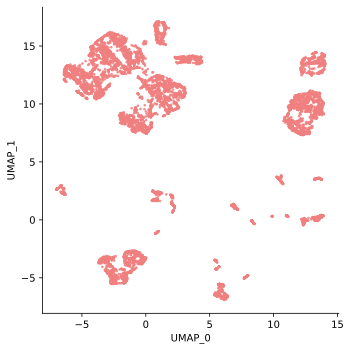

In [11]:
# applying Feature Distributed Clustering(FDC) on entire 10125 data with all features except disease features
entire_data_FDC_emb_three,entire_data_FDC_emb_two=FDC(data_others,cont_list,nom_list,ord_list,'euclidean','canberra','hamming',1,1)

## DBSCAN clustering on FDC embedding

In [12]:
def db_scan(eps,min_samples,five_d_embedding,two_d_embedding,visual, pal):
    from sklearn.cluster import DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples = min_samples)
    clusters=dbscan.fit_predict(five_d_embedding)
    (values,counts) = np.unique(clusters,return_counts=True)
    two_d_embedding['Cluster'] = clusters
    
    if visual==1:
        sns.lmplot( x="UMAP_0", y="UMAP_1",
        data=two_d_embedding,
        fit_reg=False, 
        legend=True,
        hue='Cluster', # color by cluster
        scatter_kws={"s": 3},palette=pal) # specify the point size
        plt.savefig('dbscan_ref_3dim.png', dpi=700, bbox_inches='tight')
        plt.show()
    else:
        pass
    return two_d_embedding.Cluster.to_list(),counts

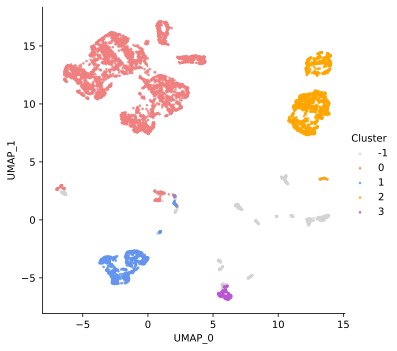

In [13]:
#setting color palette for visualization of clusters
colors_set1 = ['lightgray','lightcoral','cornflowerblue','orange','mediumorchid', 'lightseagreen','olive', 'chocolate','steelblue']
customPalette_set1 = sns.set_palette(sns.color_palette(colors_set1))


#Applying clustering algorithm on FDC embedding from entire data
entire_data_cluster_list,entire_data_cluster_counts=db_scan(0.5,140,entire_data_FDC_emb_three,entire_data_FDC_emb_two,1,customPalette_set1)


In [14]:
#Getting noise indices
non_noise_indices= np.where(np.array(entire_data_cluster_list)!=-1)

#Removing noise/outlires from FDC embedding and from entire data
entire_data_FDC_emb_three= entire_data_FDC_emb_three.iloc[non_noise_indices]
entire_data_FDC_emb_two= entire_data_FDC_emb_two.iloc[non_noise_indices]
entire_data_cluster_list= np.array(entire_data_cluster_list)[non_noise_indices]
data_others= data_others.iloc[non_noise_indices]

#Creating new cloumn for storing cluster labels 
data_others['cluster_labels']= entire_data_cluster_list

#getting binary representation for cluster labels
data_others= pd.get_dummies(data=data_others, columns=['cluster_labels'])

In [15]:
#Getting column names of encoded cluster labels
cluster_column_names=data_others.columns[-len(np.unique(entire_data_cluster_list)):].to_list()

## Dividing data set for experiments

In [16]:
#75%  of entire data for training
np.random.seed(42)
data=data_others.sample(frac=0.75) # Training data

In [17]:
#Another 25% of entire data for validation
np.random.seed(42)
data_val=data_others.drop(data.index) # Validation data

## Dividing training data into 3 folds

In [18]:
#Dividing training data into three folds

np.random.seed(42)
df_1=data.sample(frac=0.33) #fold 1

df=data.drop(df_1.index)
df_2=df.sample(frac=0.51) #fold 2

df_3=df.drop(df_2.index) #fold 3

In [19]:
np.random.seed(42)
#Possible combinations of concating 2 folds for training and using remaining fold for testing
training_folds=[pd.concat([df_1,df_2],axis=0), pd.concat([df_2,df_3],axis=0), pd.concat([df_3,df_1],axis=0)]
testing_folds=[df_3,df_1,df_2]

## Function for neural network
### Function parameters:
- n_features= dimension of input data
- hidden_dim1= dimension of first hidden layer
- hidden_dim2= dimension of second hidden layer
- out_emb_size= dimension of output data
- act1= first hidden layer activation function
- act2= second hidden layer activation function

In [20]:
def neural_network(n_features,hidden_dim1,hidden_dim2,out_emb_size,act1,act2,loss):
    np.random.seed(42)
    tf.random.set_seed(42)
    model=keras.Sequential([
         keras.layers.Dense(hidden_dim1,input_dim=n_features,activation=act1),
         keras.layers.Dense(hidden_dim1,activation=act2),
         keras.layers.Dense(out_emb_size)])
    model.compile(optimizer="adam" ,
              loss=loss, 
              metrics=['mse'])
    return model    

## Function for Cluster Incidence Matrix (CIM)
- creating a matrix to evaluate the performance based on predicted cluster labels

In [21]:
def cluster_incidence_matrix_mod(cluster_list_new):
    np.random.seed(42)
    
    matrix=np.zeros((len(cluster_list_new),len(cluster_list_new)))
    for i in range(len(cluster_list_new)):
        for j in range(len(cluster_list_new)):
                if cluster_list_new[i]==cluster_list_new[j]:
                    matrix[i,j]=1 
                else:
                    pass
    
    return matrix 

In [22]:
#Function for decoding the encoded cluster labels
def label_decoder(label_dataframe):
    label_array=np.array(label_dataframe)
    decoded_labels=[]
    for i in label_array:
        max_val=np.argmax(i)
        decoded_labels.append(max_val)
    return decoded_labels

In [23]:
colnames=[]
for i in range(len(entire_data_FDC_emb_three.columns)):
    colnames.append('c'+str(i+1))

Epoch 1/30
538/538 [==============================] - 1s 1ms/step - loss: 0.4736 - mse: 0.4736
Epoch 2/30
538/538 [==============================] - 1s 1ms/step - loss: 0.2631 - mse: 0.2631
Epoch 3/30
538/538 [==============================] - 1s 1ms/step - loss: 0.2355 - mse: 0.2355
Epoch 4/30
538/538 [==============================] - 1s 1ms/step - loss: 0.2259 - mse: 0.2259
Epoch 5/30
538/538 [==============================] - 1s 1ms/step - loss: 0.2175 - mse: 0.2175
Epoch 6/30
538/538 [==============================] - 1s 1ms/step - loss: 0.2110 - mse: 0.2110
Epoch 7/30
538/538 [==============================] - 1s 1ms/step - loss: 0.2027 - mse: 0.2027
Epoch 8/30
538/538 [==============================] - 1s 1ms/step - loss: 0.1963 - mse: 0.1963
Epoch 9/30
538/538 [==============================] - 1s 1ms/step - loss: 0.1897 - mse: 0.1897
Epoch 10/30
538/538 [==============================] - 1s 1ms/step - loss: 0.1850 - mse: 0.1850
Epoch 11/30
538/538 [============================

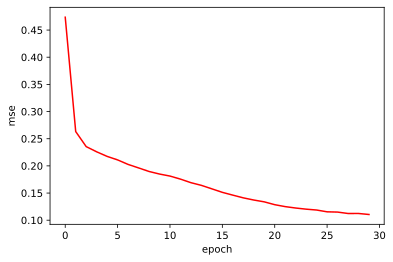

Epoch 1/30
538/538 [==============================] - 1s 1ms/step - loss: 0.1126 - mse: 0.1126
Epoch 2/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0392 - mse: 0.0392
Epoch 3/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0200 - mse: 0.0200
Epoch 4/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0176 - mse: 0.0176
Epoch 5/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0170 - mse: 0.0170
Epoch 6/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0161 - mse: 0.0161
Epoch 7/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0155 - mse: 0.0155
Epoch 8/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0155 - mse: 0.0155
Epoch 9/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0148 - mse: 0.0148
Epoch 10/30
538/538 [==============================] - 1s 1ms/step - loss: 0.0148 - mse: 0.0148
Epoch 11/30
538/538 [============================

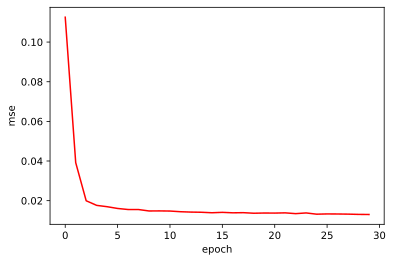

66/66 [==============================] - 0s 721us/step
Vizualization for FDC for training fold (shown in dark hue) 1and predicted clusters from neural network on testing fold (shown in corresponding light hues) 1


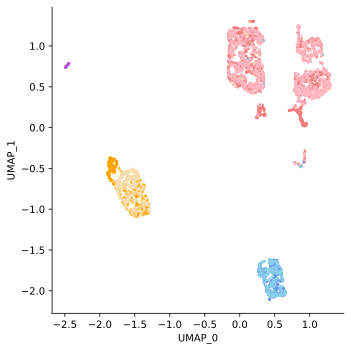

Average percentage of patients belongs to the same cluster is: 98.02617072048253%


Epoch 1/30
536/536 [==============================] - 1s 965us/step - loss: 0.4823 - mse: 0.4823
Epoch 2/30
536/536 [==============================] - 1s 989us/step - loss: 0.2682 - mse: 0.2682
Epoch 3/30
536/536 [==============================] - 1s 994us/step - loss: 0.2362 - mse: 0.2362
Epoch 4/30
536/536 [==============================] - 1s 1ms/step - loss: 0.2262 - mse: 0.2262
Epoch 5/30
536/536 [==============================] - 1s 1ms/step - loss: 0.2182 - mse: 0.2182
Epoch 6/30
536/536 [==============================] - 1s 1ms/step - loss: 0.2120 - mse: 0.2120
Epoch 7/30
536/536 [==============================] - 1s 1ms/step - loss: 0.2056 - mse: 0.2056
Epoch 8/30
536/536 [==============================] - 1s 1ms/step - loss: 0.2002 - mse: 0.2002
Epoch 9/30
536/536 [==============================] - 1s 1ms/step - loss: 0.1939 - mse: 0.1939
Epoch 10/30
536/536 [==============================] - 

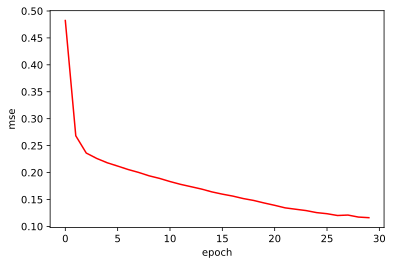

Epoch 1/30
536/536 [==============================] - 1s 1ms/step - loss: 0.1092 - mse: 0.1092
Epoch 2/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0338 - mse: 0.0338
Epoch 3/30
536/536 [==============================] - 1s 952us/step - loss: 0.0191 - mse: 0.0191
Epoch 4/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0175 - mse: 0.0175
Epoch 5/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0164 - mse: 0.0164
Epoch 6/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0159 - mse: 0.0159
Epoch 7/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0154 - mse: 0.0154
Epoch 8/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0152 - mse: 0.0152
Epoch 9/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0147 - mse: 0.0147
Epoch 10/30
536/536 [==============================] - 1s 1ms/step - loss: 0.0144 - mse: 0.0144
Epoch 11/30
536/536 [==========================

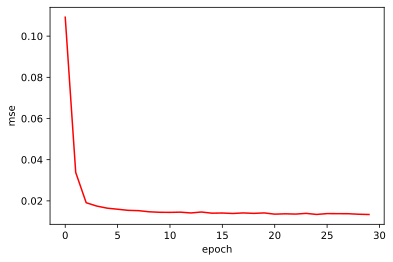

66/66 [==============================] - 0s 721us/step
Vizualization for FDC for training fold (shown in dark hue) 2and predicted clusters from neural network on testing fold (shown in corresponding light hues) 2


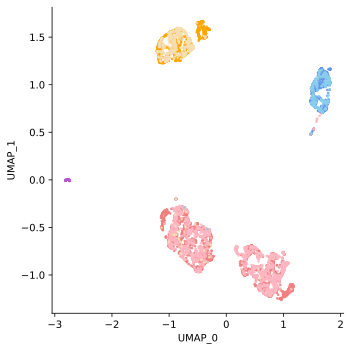

Average percentage of patients belongs to the same cluster is: 97.19978443243934%


Epoch 1/30
527/527 [==============================] - 1s 1ms/step - loss: 0.4858 - mse: 0.4858
Epoch 2/30
527/527 [==============================] - 1s 1ms/step - loss: 0.2675 - mse: 0.2675
Epoch 3/30
527/527 [==============================] - 1s 977us/step - loss: 0.2390 - mse: 0.2390
Epoch 4/30
527/527 [==============================] - 1s 981us/step - loss: 0.2300 - mse: 0.2300
Epoch 5/30
527/527 [==============================] - 1s 1ms/step - loss: 0.2222 - mse: 0.2222
Epoch 6/30
527/527 [==============================] - 1s 1ms/step - loss: 0.2174 - mse: 0.2174
Epoch 7/30
527/527 [==============================] - 1s 1ms/step - loss: 0.2137 - mse: 0.2137
Epoch 8/30
527/527 [==============================] - 1s 1ms/step - loss: 0.2075 - mse: 0.2075
Epoch 9/30
527/527 [==============================] - 1s 1ms/step - loss: 0.2018 - mse: 0.2018
Epoch 10/30
527/527 [==============================] - 1s

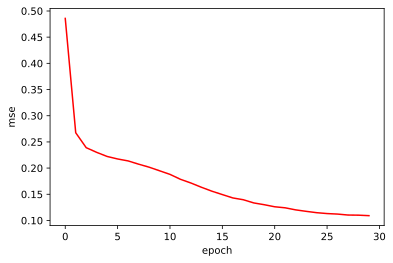

Epoch 1/30
527/527 [==============================] - 1s 1ms/step - loss: 0.1096 - mse: 0.1096
Epoch 2/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0365 - mse: 0.0365
Epoch 3/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0188 - mse: 0.0188
Epoch 4/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0174 - mse: 0.0174
Epoch 5/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0163 - mse: 0.0163
Epoch 6/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0160 - mse: 0.0160
Epoch 7/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0160 - mse: 0.0160
Epoch 8/30
527/527 [==============================] - 1s 993us/step - loss: 0.0154 - mse: 0.0154
Epoch 9/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0154 - mse: 0.0154
Epoch 10/30
527/527 [==============================] - 1s 1ms/step - loss: 0.0150 - mse: 0.0150
Epoch 11/30
527/527 [==========================

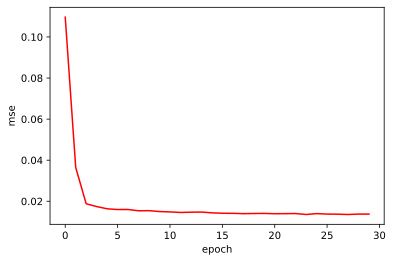

69/69 [==============================] - 0s 912us/step
Vizualization for FDC for training fold (shown in dark hue) 3and predicted clusters from neural network on testing fold (shown in corresponding light hues) 3


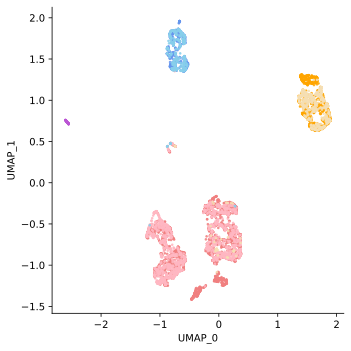

Average percentage of patients belongs to the same cluster is: 97.12274413498312%








In [24]:
np.random.seed(42)
count=0
fold_readings=[]
while count<3:
    FDC_emb_three_train=entire_data_FDC_emb_three.loc[list(training_folds[count].index)] #3D FDC embedding of training folds from entire training data
    FDC_emb_two_train=entire_data_FDC_emb_two.loc[list(training_folds[count].index)] #2D embedding of training folds from entire training data
    FDC_emb_three_train.columns=colnames
    
    #Thirty dimensional data of training fold as features_matrix(X_train) 
    features_matrix=np.array(training_folds[count].drop(cluster_column_names, axis=1,inplace=False)) #X_train
    
    #three dimensional FDC embedding of training fold as target_matrix(y_train)
    target_matrix=np.array(FDC_emb_three_train) #y_train
    
    #Train a neural network to get five dimensional embedding
    model_1=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_matrix[0]),"relu","sigmoid","mse")
    history=model_1.fit(features_matrix,target_matrix,epochs=30,batch_size=8)
    print('\n')
    print('Training history across epochs for fold ',count+1)
    plt.plot(history.history['mse'],'r')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()
    
    #Using same thirty dimensional features_matrix(X_train) from first neural network and encoded cluster labels of training fold as target_labels_matrix(y_train) 
    target_labels_matrix=np.array(training_folds[count].loc[:,cluster_column_names]) #y
    
    
    #Train a neural network to get encoded cluster labels
    model_2=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_labels_matrix[0]),"relu","softmax","mse")
    history=model_2.fit(features_matrix,target_labels_matrix,epochs=30,batch_size=8)
    print('\n')
    print('Training history across epochs for fold ',count+1)
    plt.plot(history.history['mse'],'r')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.show()
    
    #Decoding cluster labels of training fold
    decoded_target_labels_matrix=label_decoder(target_labels_matrix)

    #Actual encoded cluster labels of testing fold for metric calculation  
    ref_clusters=testing_folds[count].loc[:,cluster_column_names] 
    #Decoding encoded cluster labels of testing fold
    decoded_ref_clusters=label_decoder(ref_clusters)
    

    #predicting testing fold to get three dim embedding using trained model_1
    testing_data=testing_folds[count].drop(cluster_column_names, axis=1,inplace=False)
    predicted_3dim=pd.DataFrame(model_1.predict(testing_data), columns=colnames)
    
    #UMAP on predicted 3D embedding
    predicted_2dim=feature_clustering(30,0.01, "euclidean", predicted_3dim, 0)

    #predicting testing fold to get encoded cluster labels using trained model_2
    predicted_clusters=pd.DataFrame(model_2.predict(testing_data))
    
    #Decoding predicted encoded cluster labels
    decoded_predicted_clusters=label_decoder(predicted_clusters)
    
    
    #concatinating training and predicted 3D embedding
    concatenated_3dim=pd.concat([FDC_emb_three_train,predicted_3dim])
    
    #UMAP on concatinated embedding
    two_dim_viz=feature_clustering(30, 0.01, 'euclidean', concatenated_3dim, 0)
    
    #Concatinating decoded cluster labels of training fold and predicted testing fold
    concatenated_cluster_labels=np.concatenate([np.array(decoded_target_labels_matrix),np.array(decoded_predicted_clusters)+len(np.unique(decoded_target_labels_matrix))])
    
    two_dim_viz['Cluster']= concatenated_cluster_labels
    
    
    #Setting dark colors for training folds    
    darkerhues=['lightcoral','cornflowerblue','orange','mediumorchid', 'lightseagreen','olive', 'chocolate','steelblue']
    colors_set2=[]
    for i in range(len(np.unique(decoded_target_labels_matrix))):
        colors_set2.append(darkerhues[i])
    
    #Concatinating dark colors for training folds and corresponding light colors for testing folds
    colors_set2=colors_set2+["lightpink", 'skyblue', 'wheat', "plum","paleturquoise",  "lightgreen",  'burlywood','lightsteelblue']
    
    print('Vizualization for FDC for training fold (shown in dark hue) '+str(count+1) + 'and predicted clusters from neural network on testing fold (shown in corresponding light hues) '+str(count+1))
    
    #visualizing the clusters of both training and testing folds
    sns.lmplot( x="UMAP_0", y="UMAP_1", data=two_dim_viz, fit_reg=False, legend=False, hue='Cluster', scatter_kws={"s": 3},palette=sns.set_palette(sns.color_palette(colors_set2))) 
    plt.show()
    
    #Metric calculation

    CIM_predicted=cluster_incidence_matrix_mod(np.array(decoded_predicted_clusters))#Cluster incidence metric for predicted clusters
    CIM_reference=cluster_incidence_matrix_mod(np.array(decoded_ref_clusters))#Cluster incidence metric for reference clusters
    Product=np.dot(CIM_predicted,CIM_reference)
    cluster_incdences_in_data=np.sum(CIM_reference,axis=1)  
    mean_points_in_same_clusters=np.mean(np.diagonal(Product)/cluster_incdences_in_data)
    fold_readings.append(mean_points_in_same_clusters*100)
    
    print("Average percentage of patients belongs to the same cluster is: {}%".format(mean_points_in_same_clusters*100))
    print('\n')
    count+=1


print('\n')
print('\n')


In [25]:
print('Average percentage of patients belonging to the same cluster over all three folds:', np.mean(np.array(fold_readings)))

Average percentage of patients belonging to the same cluster over all three folds: 97.44956642930167


## Validation

Epoch 1/30
800/800 [==============================] - 1s 999us/step - loss: 0.4169 - mse: 0.4169
Epoch 2/30
800/800 [==============================] - 1s 1ms/step - loss: 0.2428 - mse: 0.2428
Epoch 3/30
800/800 [==============================] - 1s 1ms/step - loss: 0.2264 - mse: 0.2264
Epoch 4/30
800/800 [==============================] - 1s 2ms/step - loss: 0.2173 - mse: 0.2173
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.2107 - mse: 0.2107
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.2046 - mse: 0.2046
Epoch 7/30
800/800 [==============================] - 1s 991us/step - loss: 0.1972 - mse: 0.1972
Epoch 8/30
800/800 [==============================] - 1s 1ms/step - loss: 0.1894 - mse: 0.1894
Epoch 9/30
800/800 [==============================] - 1s 1ms/step - loss: 0.1802 - mse: 0.1802
Epoch 10/30
800/800 [==============================] - 1s 1ms/step - loss: 0.1716 - mse: 0.1716
Epoch 11/30
800/800 [========================

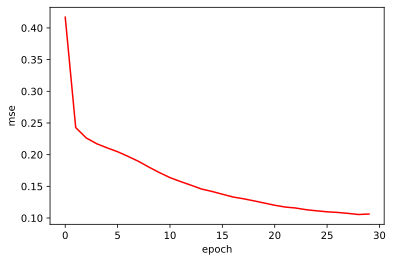

Epoch 1/30
800/800 [==============================] - 1s 969us/step - loss: 0.0944 - mse: 0.0944
Epoch 2/30
800/800 [==============================] - 1s 960us/step - loss: 0.0228 - mse: 0.0228
Epoch 3/30
800/800 [==============================] - 1s 947us/step - loss: 0.0174 - mse: 0.0174
Epoch 4/30
800/800 [==============================] - 1s 940us/step - loss: 0.0163 - mse: 0.0163
Epoch 5/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0160 - mse: 0.0160
Epoch 6/30
800/800 [==============================] - 1s 1ms/step - loss: 0.0153 - mse: 0.0153
Epoch 7/30
800/800 [==============================] - 1s 980us/step - loss: 0.0150 - mse: 0.0150
Epoch 8/30
800/800 [==============================] - 1s 941us/step - loss: 0.0148 - mse: 0.0148
Epoch 9/30
800/800 [==============================] - 1s 962us/step - loss: 0.0148 - mse: 0.0148
Epoch 10/30
800/800 [==============================] - 1s 958us/step - loss: 0.0145 - mse: 0.0145
Epoch 11/30
800/800 [============

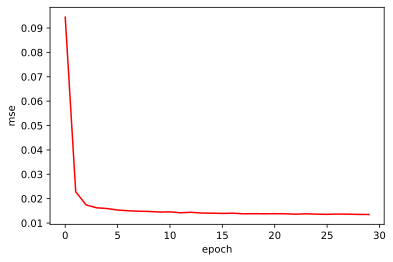

67/67 [==============================] - 0s 709us/step
Vizualization for FDC for training data (shown in dark hue) and predicted clusters from neural network on validation data (shown in corresponding light hues) 


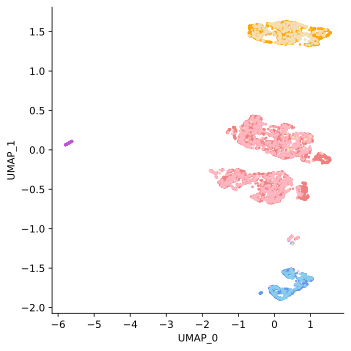

Average percentage of patients belongs to the same cluster is: 97.18515456198324%








In [26]:
np.random.seed(42)

FDC_emb_three_data=entire_data_FDC_emb_three.loc[list(data.index)] #5D FDC embedding of training fold from entire data
FDC_emb_two_data=entire_data_FDC_emb_two.loc[list(data.index)] #2D embedding of training fold from entire data
FDC_emb_three_data.columns=colnames

#Thirty dimensional data of training fold as features_matrix(X_train) 
features_matrix=np.array(data.drop(cluster_column_names, axis=1,inplace=False)) #X_train

#Five dimensional FDC embedding of training fold as target_matrix(y_train)
target_matrix=np.array(FDC_emb_three_data) #y_train

#Train a neural network to get five dimensional embedding
model_1=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_matrix[0]),"relu","sigmoid","mse")
history=model_1.fit(features_matrix,target_matrix,epochs=30,batch_size=8)
print('\n')
print('Training history across epochs for training data ')
plt.plot(history.history['mse'],'r')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

#Using same thirty dimensional features_matrix(X_train) from first neural network and encoded cluster labels of training fold as target_labels_matrix(y_train) 
target_labels_matrix=np.array(data.loc[:,cluster_column_names]) #y


#Train a neural network to get encoded cluster labels
model_2=neural_network(len(features_matrix[0]),int(0.6*len(features_matrix[0])),int(0.36*len(features_matrix[0])),len(target_labels_matrix[0]),"relu","softmax","mse")
history=model_2.fit(features_matrix,target_labels_matrix,epochs=30,batch_size=8)
print('\n')
print('Training history across epochs for training data ')
plt.plot(history.history['mse'],'r')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

#Decoding cluster labels of training fold
decoded_target_labels_matrix=label_decoder(target_labels_matrix)

#Actual encoded cluster labels of validation data for metric calculation  
ref_clusters=data_val.loc[:,cluster_column_names] 
#Decoding encoded cluster labels of validation data
decoded_ref_clusters=label_decoder(ref_clusters)


#predicting validation data to get five dim embedding using trained model_1
validation_data=data_val.drop(cluster_column_names, axis=1,inplace=False)
predicted_3dim=pd.DataFrame(model_1.predict(validation_data), columns=colnames)

#UMAP on predicted 5D embedding
predicted_2dim=feature_clustering(30,0.01, "euclidean", predicted_3dim, 0)

#predicting validation data to get encoded cluster labels using trained model_2
predicted_clusters=pd.DataFrame(model_2.predict(validation_data))

#Decoding predicted encoded cluster labels
decoded_predicted_clusters=label_decoder(predicted_clusters)


#concatinating training and predicted 5D embedding
concatenated_3dim=pd.concat([FDC_emb_three_data,predicted_3dim])

#UMAP on concatinated embedding
two_dim_viz=feature_clustering(30, 0.01, 'euclidean', concatenated_3dim, 0)

#Concatinating decoded cluster labels of training data and predicted validation data
concatenated_cluster_labels=np.concatenate([np.array(decoded_target_labels_matrix),np.array(decoded_predicted_clusters)+len(np.unique(decoded_target_labels_matrix))])

two_dim_viz['Cluster']= concatenated_cluster_labels



#Setting dark colors for training data    
darkerhues=['lightcoral','cornflowerblue','orange','mediumorchid', 'lightseagreen','olive', 'chocolate','steelblue']
colors_set2=[]
for i in range(len(np.unique(decoded_target_labels_matrix))):
    colors_set2.append(darkerhues[i])

#Concatinating dark colors for training data and corresponding light colors for validation data
colors_set2=colors_set2+["lightpink", 'skyblue', 'wheat', "plum","paleturquoise",  "lightgreen",  'burlywood','lightsteelblue']

print('Vizualization for FDC for training data (shown in dark hue) '+ 'and predicted clusters from neural network on validation data (shown in corresponding light hues) ')

#visualizing the clusters of both training and validation data
sns.lmplot( x="UMAP_0", y="UMAP_1", data=two_dim_viz, fit_reg=False, legend=False, hue='Cluster', scatter_kws={"s": 3},palette=sns.set_palette(sns.color_palette(colors_set2))) 
plt.show()

#Metric calculation

CIM_predicted=cluster_incidence_matrix_mod(np.array(decoded_predicted_clusters))#Cluster incidence metric for predicted clusters
CIM_reference=cluster_incidence_matrix_mod(np.array(decoded_ref_clusters))#Cluster incidence metric for reference clusters
Product=np.dot(CIM_predicted,CIM_reference)
cluster_incidences_in_data=np.sum(CIM_reference,axis=1)  
mean_points_in_same_clusters=np.mean(np.diagonal(Product)/cluster_incidences_in_data)
fold_readings.append(mean_points_in_same_clusters*100)

print("Average percentage of patients belongs to the same cluster is: {}%".format(mean_points_in_same_clusters*100))
print('\n')



print('\n')
print('\n')
